# [CS 5180 only.] Ex8 Q2: Policy-gradient methods

In [1]:
from collections import deque
from gymnasium import spaces
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.distributions import Categorical
import torch.nn.functional as F
import tqdm

## Four Rooms environment

In the question, we will implement several policy-gradient methods and apply them once again on our favorite domain, Four Rooms. The environment is implemented below in a Gymnasium-like interface. Code for plotting learning curves with confidence bands is also provided.

In [2]:
class FourRooms(object):
    def __init__(self):
        # The grid for the Four Rooms domain
        self.grid = np.array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                              [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

        # Observation (state) space consists of all empty cells
        # To improve interpretability, we flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        self.observation_space = np.argwhere(self.grid == 0.0).tolist()  # Fine all empty cells
        self.observation_space = self.arr_coords_to_four_room_coords(self.observation_space)

        # Action space
        self.action_movement = {0: np.array([0, 1]),  # up
                                1: np.array([0, -1]),  # down
                                2: np.array([-1, 0]),  # left
                                3: np.array([1, 0])}  # right
        self.action_space = spaces.Discrete(4)

        # Start location
        self.start_location = [0, 0]

        # Goal location
        self.goal_location = [10, 10]

        # Wall locations
        self.walls = np.argwhere(self.grid == 1.0).tolist()  # find all wall cells
        self.walls = self.arr_coords_to_four_room_coords(self.walls)  # convert to Four Rooms coordinates

        # This is an episodic task, with a timeout of 459 steps
        self.max_time_steps = 459

        # Tracking variables during a single episode
        self.agent_location = None  # Track the agent's location in one episode.
        self.action = None  # Track the agent's action
        self.t = 0  # Track the current time step in one episode

    @staticmethod
    def arr_coords_to_four_room_coords(arr_coords_list):
        """
        Function converts the array coordinates ((row, col), origin is top left)
        to the Four Rooms coordinates ((x, y), origin is bottom left)
        E.g., The coordinates (0, 0) in the numpy array is mapped to (0, 10) in the Four Rooms coordinates.
        Args:
            arr_coords_list (list): List variable consisting of tuples of locations in the numpy array

        Return:
            four_room_coords_list (list): List variable consisting of tuples of converted locations in the
                                          Four Rooms environment.
        """
        # Flip the coordinates from (row_idx, column_idx) -> (x, y),
        # where x = column_idx, y = 10 - row_idx
        four_room_coords_list = [(column_idx, 10 - row_idx) for (row_idx, column_idx) in arr_coords_list]
        return four_room_coords_list

    def reset(self):
        # Reset the agent's location to the start location
        self.agent_location = self.start_location

        # Reset the timeout tracker to be 0
        self.t = 0

        # Reset the information
        info = {}
        return self.agent_location, info

    def step(self, action):
        """
        Args:
            action (int): Int variable (i.e., 0 for "up"). See self.action_movement above for more details.
        """
        # With probability 0.8, the agent takes the correct direction.
        # With probability 0.2, the agent takes one of the two perpendicular actions.
        # For example, if the correct action is "LEFT", then
        #     - With probability 0.8, the agent takes action "LEFT";
        #     - With probability 0.1, the agent takes action "UP";
        #     - With probability 0.1, the agent takes action "DOWN".
        if np.random.uniform() < 0.2:
            if action == 2 or action == 3:
                action = np.random.choice([0, 1], 1)[0]
            else:
                action = np.random.choice([2, 3], 1)[0]

        # Convert the agent's location to array
        loc_arr = np.array(self.agent_location)

        # Convert the action name to movement array
        act_arr = self.action_movement[action]

        # Compute the agent's next location
        next_agent_location = np.clip(loc_arr + act_arr,
                                      a_min=np.array([0, 0]),
                                      a_max=np.array([10, 10])).tolist()

        # Check if the agent crashes into walls; if so, it stays at the current location.
        if tuple(next_agent_location) in self.walls:
            next_agent_location = self.agent_location

        # Compute the reward (1 iff next state is goal location)
        reward = 1.0 if next_agent_location == self.goal_location else 0.0

        # Check termination/truncation
        # If agent reaches the goal, reward = 1, terminated = True
        # If timeout is reached, reward = 0, truncated = True
        terminated = False
        truncated = False
        if reward == 1.0:
            terminated = True
        elif self.t == self.max_time_steps:
            truncated = True

        # Update the agent's location, action, and time step trackers
        self.agent_location = next_agent_location
        self.action = action
        self.t += 1

        return next_agent_location, reward, terminated, truncated, {}

    def render(self):
        # Plot the agent and the goal
        # empty cell = 0
        # wall cell = 1
        # agent cell = 2
        # goal cell = 3
        plot_arr = self.grid.copy()
        plot_arr[10 - self.agent_location[1], self.agent_location[0]] = 2
        plot_arr[10 - self.goal_location[1], self.goal_location[0]] = 3
        plt.clf()
        plt.title(f"state={self.agent_location}, act={self.action_movement[self.action]}")
        plt.imshow(plot_arr)
        plt.show(block=False)
        plt.pause(0.1)

    @staticmethod
    def test():
        env = FourRooms()
        state, info = env.reset()

        for _ in range(1000):
            action = env.action_space.sample()
            next_state, reward, terminated, truncated, info = env.step(action)
            env.render()
            if terminated or truncated:
                state, info = env.reset()
            else:
                state = next_state

# Un-comment to run test function
# FourRooms.test()

In [3]:
def moving_average(data, *, window_size = 50):
    """Smooths 1-D data array using a moving average.

    Args:
        data: 1-D numpy.array
        window_size: Size of the smoothing window

    Returns:
        smooth_data: A 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

In [4]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title, smoothing = True):
    """
    Args:
        arr_list (list): List of results arrays to plot
        legend_list (list): List of legends corresponding to each result array
        color_list (list): List of color corresponding to each result array
        ylabel (string): Label of the vertical axis

        Make sure the elements in the arr_list, legend_list, and color_list
        are associated with each other correctly (in the same order).
        Do not forget to change the ylabel for different plots.
    """
    # Set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the vertical labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # Plot results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # Compute the standard error (of raw data, not smoothed)
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # Plot the mean
        averages = moving_average(arr.mean(axis=0)) if smoothing else arr.mean(axis=0)
        h, = ax.plot(range(arr.shape[1]), averages, color=color, label=legend)
        # Plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), averages - arr_err, averages + arr_err, alpha=0.3,
                        color=color)
        # Save the plot handle
        h_list.append(h)

    # Plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

## Part (a): REINFORCE algorithm (page 328)

### Policy network

We will use and learn a neural network to represent the stochastic policy $\pi(a|s)$. The architecture of the neural network should be:

Layer 1: Linear, input size 3 (size of observation space, see below), output size 128\
Activation 1: ReLU\
Layer 2: Linear, input size 128, output size 4 (size of action space)\
Activation 2: Softmax (to ensure output is a probability distribution)

For the input observation, instead of using the original state = $[x, y]$, we represent each state as $\left[ \frac{x}{10}, \frac{y}{10}, 1 \right]$, which normalizes the input.

In [5]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the neural network here
        """
        # Define the first linear layer
        self.fc1 = nn.Linear(in_features=3, out_features=128)
        # Define the second linear layer
        self.fc2 = nn.Linear(in_features=128, out_features=4)

    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation
        """
        # Forward pass through the first layer and ReLU activation
        x = F.relu(self.fc1(x))
        # Forward pass through the second layer
        x = self.fc2(x)
        # Apply softmax to the final layer's output to get a probability distribution over actions
        return F.softmax(x, dim=-1)

### REINFORCE agent with policy network

In [6]:
class REINFORCEAgent(object):
    def __init__(self):
        # Create the policy network
        self.policy_net = PolicyNet()

    def get_action(self, state):
        """ Function to derive an action given a state
            Args:
                state (list): [x/10, y/10, 1]
                
            Returns:
                action index (int), log_prob (ln(\pi(action|state)))
        """
        state_tensor = torch.tensor(state).float().view(1, -1)
        probs = self.policy_net(state_tensor)
        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob

### REINFORCE training loop

In [7]:
import torch.optim as optim
class REINFORCEAgentTrainer(object):
    def __init__(self, agent, env, params):
        # Agent object
        self.agent = agent
        
        # Environment object
        self.env = env
        
        # Training parameters
        self.params = params

        # Lists to store the log probabilities and rewards for one episode
        self.saved_log_probs = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']

        # Create the optimizer
        """ YOUR CODE HERE:
                Use the Adam optimizer with the learning rate in params
        """
        self.optimizer = optim.Adam(self.agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_agent_policy_network(self):
        # List to store the policy loss for each time step
        policy_loss = []
        
        # List to store the return for each time step
        returns = deque()

        """ YOUR CODE HERE:
                Compute the return for each time step
                
                Hint: We usually compute the return from the end. Remember to append it 
                      correctly. You can use "returns.appendleft(G)"
        """
        # Compute returns for every time step

        G = 0
        for reward in reversed(self.saved_rewards):
            G = reward + self.gamma * G
            returns.appendleft(G)
        returns = torch.tensor(list(returns))

        """ YOUR CODE HERE:
                We now have the return and log probability for each time step.
                Compute the `policy loss' for each time step
                (whose gradient appears in the pseudocode).
        """
        for log_prob, r in zip(self.saved_log_probs, returns):
            # Compute the policy loss for each time step
            policy_loss.append(-log_prob * r)

        # Sum all the policy loss terms across all time steps
        policy_loss = torch.cat(policy_loss).sum()
        
        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()
        
        # After backpropagation, clear the data
        del self.saved_log_probs[:]
        del self.saved_rewards[:]

        return returns[0].item(), policy_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """
        
        """ YOUR CODE HERE:
                Implement the code to collect one episode. 
                
                Specifically, we only collect the rewards and corresponding log probability, which
                should be stored in "self.saved_rewards" and "self.saved_log_probs", respectively. 
                
                This is because we only need the return at each time step and log probability
                to update the weights of the policy.
      
        """

        state, _ = self.env.reset()
        done = False
        while not done:
            state_features = self.compute_state_feature(state)
            action, log_prob = self.agent.get_action(state_features)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            self.saved_rewards.append(reward)
            self.saved_log_probs.append(log_prob)
            state = next_state
            done = terminated or truncated

    def run_train(self):        
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []
        
        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the REINFORCE algorithm here.
            """
            # Collect one episode
            self.rollout()

            # Update the policy using the collected episode
            G, loss = self.update_agent_policy_network()
            
            # Save the return and loss
            train_returns.append(G)
            train_losses.append(loss)
            
            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")
        
        return train_returns, train_losses

### Evaluation of REINFORCE on Four Rooms

We will run 10 trials with 10K episodes as in past assignments, which will take between 1-2 hours. If this takes too long, you can halve both the trials and number of episodes within each trial. As usual, you should set this to be much lower during development and debugging.

In [8]:
if __name__ == "__main__":
    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 10,
        'learning_rate': 1e-3,
        'gamma': 0.99
    }

    reinforce_returns = []
    reinforce_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = REINFORCEAgent()
        my_trainer = REINFORCEAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()
        
        reinforce_returns.append(returns)
        reinforce_losses.append(losses)

Episode: 9999 | Return: 0.5526834726333618 | Loss: 23.43: 100%|██████████| 10000/10000 [06:58<00:00, 23.89it/s]  
Episode: 9999 | Return: 0.4386174976825714 | Loss: 42.66: 100%|██████████| 10000/10000 [09:40<00:00, 17.22it/s]  
Episode: 9999 | Return: 0.30545902252197266 | Loss: 22.39: 100%|██████████| 10000/10000 [08:38<00:00, 19.30it/s] 
Episode: 9999 | Return: 0.7105532288551331 | Loss: 11.31: 100%|██████████| 10000/10000 [07:54<00:00, 21.08it/s]  
Episode: 9999 | Return: 0.5870367884635925 | Loss: 16.70: 100%|██████████| 10000/10000 [08:05<00:00, 20.58it/s]  
Episode: 9999 | Return: 0.36603233218193054 | Loss: 39.94: 100%|██████████| 10000/10000 [06:49<00:00, 24.41it/s] 
Episode: 9999 | Return: 0.6491026282310486 | Loss: 31.73: 100%|██████████| 10000/10000 [08:09<00:00, 20.41it/s]  
Episode: 9999 | Return: 0.15735328197479248 | Loss: 47.82: 100%|██████████| 10000/10000 [09:04<00:00, 18.35it/s] 
Episode: 9999 | Return: 0.44304797053337097 | Loss: 25.61: 100%|██████████| 10000/10000 

### Plot learning and loss curves

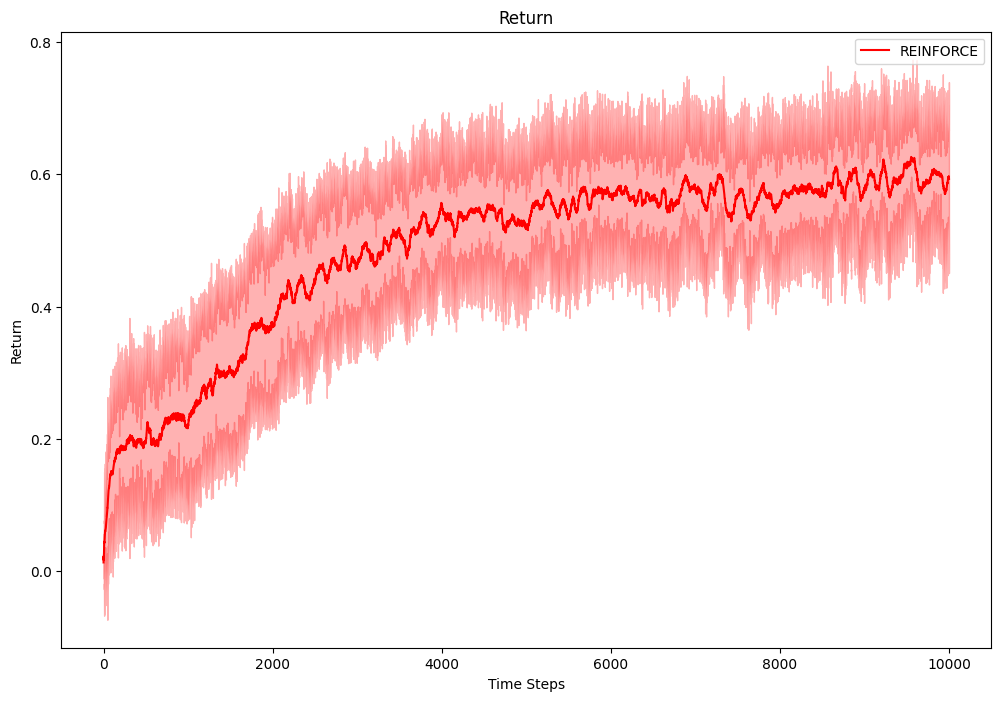

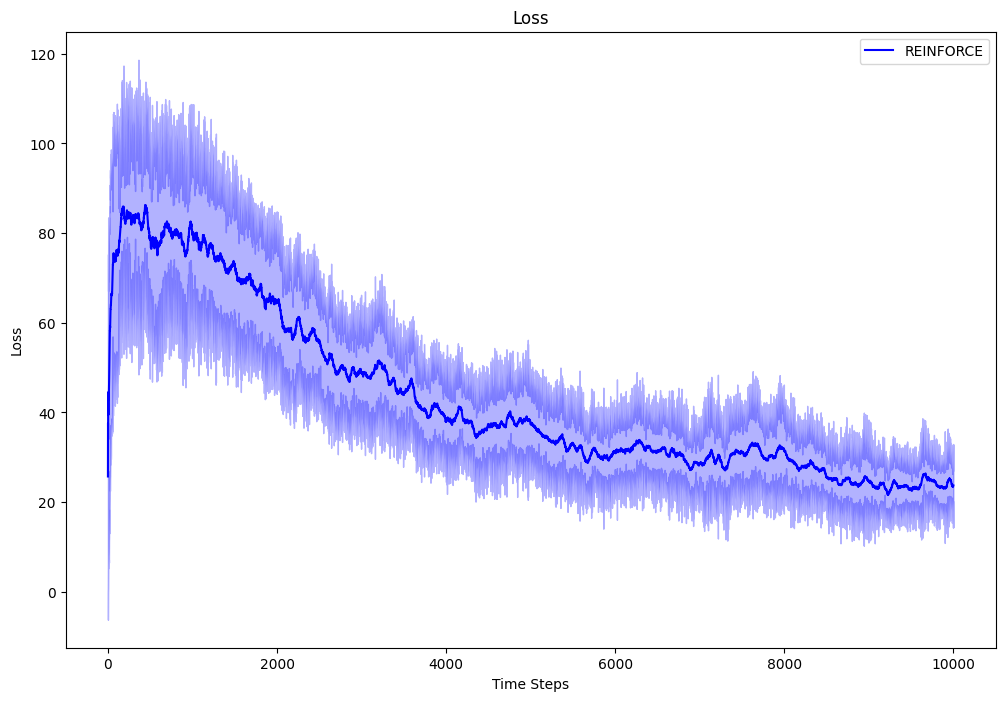

In [9]:
plot_curves([np.array(reinforce_returns)], ['REINFORCE'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(reinforce_losses)], ['REINFORCE'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (b): REINFORCE with baseline (page 330)

In this version of REINFORCE, we additionally learn a critic network (state-value function) to act as the baseline. In this context, the policy is sometimes referred to as the "actor", but the textbook reserves this terminology for the algorithm in part (c).

In [10]:
# Policy and value networks
class REINFORCEBaselineNet(nn.Module):
    def __init__(self):
        super(REINFORCEBaselineNet, self).__init__()

        """ YOUR CODE HERE:
                Implement the critic network here. The architecture should be:
                
                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 1
                Activation 2: Identity (or none)
        """

        
        # Critic network layers
        self.critic_fc1 = nn.Linear(3, 128)
        self.critic_fc2 = nn.Linear(128, 1)

        """ YOUR CODE HERE:
                Implement the actor network here. The architecture should be (same as before):
                
                Layer 1: Linear, input size 3, output size 128
                Activation 1: ReLU
                Layer 2: Linear, input size 128, output size 4
                Activation 2: Softmax
        """

        # Actor network layers
        self.actor_fc1 = nn.Linear(3, 128)
        self.actor_fc2 = nn.Linear(128, 4)

    def forward(self, x):
        """ YOUR CODE HERE:
                Implement the forward propagation for both actor and critic networks
        """

        # Actor network forward pass
        actor_x = F.relu(self.actor_fc1(x))
        action_probs = F.softmax(self.actor_fc2(actor_x), dim=-1)
        
        # Critic network forward pass
        critic_x = F.relu(self.critic_fc1(x))
        state_value = self.critic_fc2(critic_x) # No activation, predicting a value

        return state_value, action_probs

In [11]:
# REINFORCE-with-baseline agent
class REINFORCEBaselineAgent(object):
    def __init__(self):
        # Create the actor and critic networks
        self.policy_net = REINFORCEBaselineNet()

    def get_action(self, state):
        # Sample an action from the actor network, return the action and its log probability,
        # and return the state value according to the critic network
        state_tensor = torch.tensor(state).float().view(1, -1)
        state_value, action_probs = self.policy_net(state_tensor)
        m = Categorical(action_probs)
        action = m.sample()
        log_prob = m.log_prob(action)
        return action.item(), log_prob, state_value

In [12]:
# REINFORCE-with-baseline training loop
class REINFORCEBaselineAgentTrainer(object):
    def __init__(self, agent, env, params):
        # Agent object
        self.agent = agent
        
        # Environment object
        self.env = env
        
        # Training parameters
        self.params = params

        # Lists to store the log probabilities, state values, and rewards for one episode
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []

        # Gamma
        self.gamma = params['gamma']

        # Create the optimizer
        """ YOUR CODE HERE:
                Implement the Adam optimizer with the learning rate in params
        """
        self.optimizer = optim.Adam(self.agent.policy_net.parameters(), lr=params['learning_rate'])

    @staticmethod
    def compute_state_feature(state):
        return [state[0] / 10, state[1] / 10, 1]

    def update_agent_policy_network(self):
        # List to store the policy loss for each time step
        policy_loss = []
        
        # List to store the value loss for each time step
        value_loss = []
        
        # List to store the return for each time step
        returns = deque()

        """ YOUR CODE HERE:
                Compute the return for each time step
                
                Hint: We usually compute the return from the end. Remember to append it 
                      correctly. You can use "returns.appendleft(G)"
        """
        # Compute returns for every time step

        G = 0
        for r in reversed(self.saved_rewards):
            G = r + self.gamma * G
            returns.appendleft(G)
        returns = torch.tensor(list(returns))

        """ YOUR CODE HERE:
                We now have the return, state value, and log probability for each time step.
                Compute the `policy loss' and `value loss' for each time step
                (whose gradients appear in the pseudocode).
        """
        for log_prob, val, G in zip(self.saved_log_probs, self.saved_state_values, returns):
            # Compute the policy and value loss for each time step
            advantage = G - val.item()
            policy_loss.append(-log_prob * advantage)  # Actor loss
            value_loss.append(F.smooth_l1_loss(val, torch.tensor([G])))  # Critic loss

        # Compute the total loss
        total_loss = torch.stack(policy_loss).sum() + torch.stack(value_loss).sum()

        """ YOUR CODE HERE:
                Implement one step of backpropagation (gradient descent)
        """

        self.optimizer.zero_grad()
        total_loss.backward()
        self.optimizer.step()

        # After backpropagation, clear the data
        del self.saved_log_probs[:]
        del self.saved_state_values[:]
        del self.saved_rewards[:]

        return returns[0].item(), total_loss.item()

    def rollout(self):
        """ Function to collect one episode from the environment
        """
        
        """ YOUR CODE HERE:
                Implement the code to collect one episode. 
                
                Collect the rewards, state valuess and log probabilities, which should be stored in
                "self.saved_rewards", "self.saved_state_values", and "self.saved_log_probs" respectively.      
        """

        state, _ = self.env.reset()
        done = False
        while not done:
            state_features = self.compute_state_feature(state)
            action, log_prob, state_value = self.agent.get_action(state_features)
            next_state, reward, terminated, truncated, _ = self.env.step(action)

            self.saved_rewards.append(reward)
            self.saved_log_probs.append(log_prob)
            self.saved_state_values.append(state_value)

            state = next_state
            done = terminated or truncated

    def run_train(self):        
        # Lists to store the returns and losses during the training
        train_returns = []
        train_losses = []
        
        # Training loop
        ep_bar = tqdm.trange(self.params['num_episodes'])
        for ep in ep_bar:
            """ YOUR CODE HERE:
                    Implement the REINFORCE-with-baseline algorithm here.
            """
            # Collect one episode
            self.rollout()

            # Update the policy using the collected episode
            G, loss = self.update_agent_policy_network()
            
            # Save the return and loss
            train_returns.append(G)
            train_losses.append(loss)
            
            # Add description
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")
        
        return train_returns, train_losses

In [13]:
if __name__ == "__main__":
    my_env = FourRooms()

    train_params = {
        'num_episodes': 10000,
        'num_trials': 10,
        'learning_rate': 1e-3,
        'gamma': 0.99
    }

    reinforce_baseline_returns = []
    reinforce_baseline_losses = []
    for _ in range(train_params['num_trials']):
        my_agent = REINFORCEBaselineAgent()
        my_trainer = REINFORCEBaselineAgentTrainer(my_agent, my_env, train_params)
        returns, losses = my_trainer.run_train()
        
        reinforce_baseline_returns.append(returns)
        reinforce_baseline_losses.append(losses)

  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\raghu\AppData\Local\Temp\ipykernel_49944\2247288937.py:64: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_loss.append(F.smooth_l1_loss(val, torch.tensor([G])))  # Critic loss
Episode: 9999 | Return: 0.7547193169593811 | Loss: 1.25: 100%|██████████| 10000/10000 [08:08<00:00, 20.47it/s]   
Episode: 9999 | Return: 0.724980354309082 | Loss: 0.36: 100%|██████████| 10000/10000 [17:20<00:00,  9.61it/s]     
Episode: 9999 | Return: 0.5255964994430542 | Loss: -1.40: 100%|██████████| 10000/10000 [08:59<00:00, 18.53it/s]  
Episode: 9999 | Return: 0.770043134689331 | Loss: 0.68: 100%|██████████| 10000/10000 [09:17<00:00, 17.95it/s]    
Episode: 9999 | Return: 0.7177305221557617 | Loss: 1.56: 100%|██████████| 10000/10000 [08:08<00:00, 20.46it/s]   
Episode: 9999 | Return: 0.63618

### Plot learning and loss curves

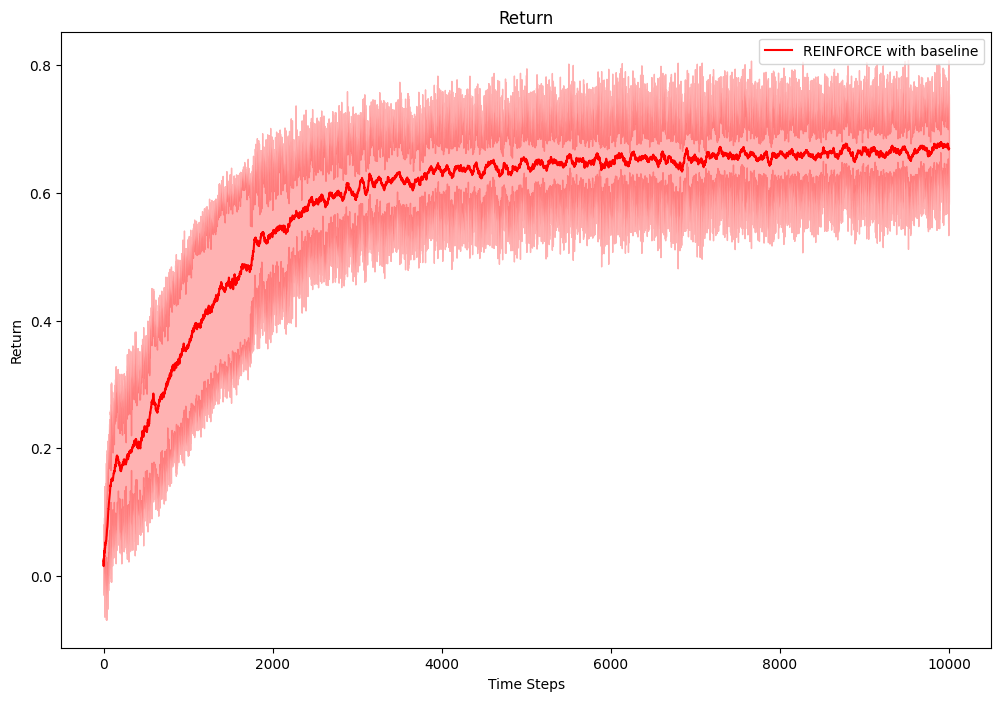

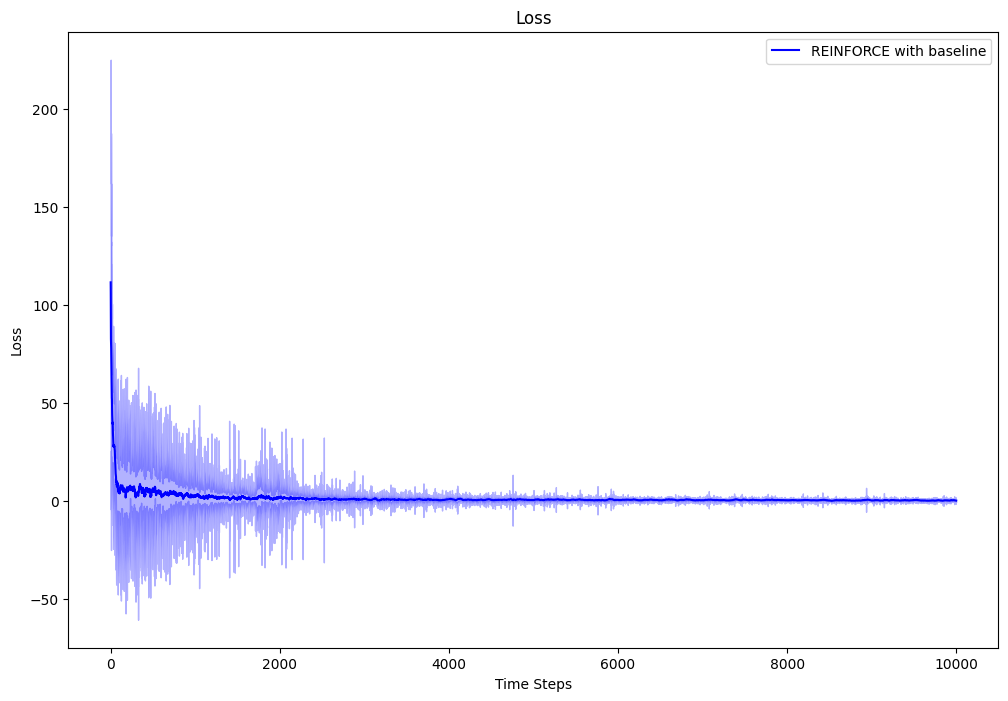

In [14]:
plot_curves([np.array(reinforce_baseline_returns)], ['REINFORCE with baseline'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(reinforce_baseline_losses)], ['REINFORCE with baseline'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (c): One-step actor-critic (page 332)

Implement one-step actor-critic and apply it to Four Rooms, similar to the previous parts. Most of the previous code is reusable, although notice that updates can technically occur after every environment step (instead of waiting until the end of the episode), since REINFORCE uses a Monte-Carlo learning target whereas actor-critic uses the one-step TD error.

In [15]:
class ActorCriticNet(nn.Module):
    def __init__(self):
        super(ActorCriticNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)  # Shared input layer

        # Actor
        self.actor_fc = nn.Linear(128, 4)  # Assuming 4 actions

        # Critic
        self.critic_fc = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_probs = F.softmax(self.actor_fc(x), dim=-1)
        state_value = self.critic_fc(x)
        return action_probs, state_value


In [16]:
class ActorCriticAgent:
    def __init__(self, model):
        self.model = model

    def get_action(self, state):
        state = torch.tensor([state], dtype=torch.float)
        probs, value = self.model(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action), value

In [17]:
from tqdm import tqdm
class ActorCriticTrainer(object):
    def __init__(self, environment, agent, optimizer, gamma):
        self.env = environment
        self.agent = agent
        self.optimizer = optimizer
        self.gamma = gamma

        # Placeholder for storing experiences from one rollout
        self.saved_log_probs = []
        self.saved_state_values = []
        self.saved_rewards = []

    def compute_state_feature(self, state):
        """Normalize state and add a bias term."""
        return [state[0] / 10, state[1] / 10, 1]

    def rollout(self):
        """Collects one episode of interaction with the environment."""
        state, _ = self.env.reset()
        state = self.compute_state_feature(state)
        
        while True:
            action, log_prob, value = self.agent.get_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            next_state = self.compute_state_feature(next_state)
            
            self.saved_log_probs.append(log_prob)
            self.saved_state_values.append(value)
            self.saved_rewards.append(reward)

            state = next_state

            if terminated or truncated:
                break

    def update_agent_policy_network(self):
        """Updates the agent's policy network based on collected experience."""
        R = 0
        policy_losses = []
        value_losses = []
        returns = []

        # Calculate returns in reverse order
        for r in self.saved_rewards[::-1]:
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(list(returns))

        for log_prob, value, R in zip(self.saved_log_probs, self.saved_state_values, returns):
            advantage = R - value.item()
            
            # Policy gradient loss
            policy_losses.append(-log_prob * advantage)

            # Value function loss
            value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))

        self.optimizer.zero_grad()
        loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
        loss.backward()
        self.optimizer.step()

        # Clear the storage
        del self.saved_log_probs[:]
        del self.saved_state_values[:]
        del self.saved_rewards[:]

        return returns[0].item(), loss.item()

    def train(self, num_episodes):
        """Main training loop."""
        episode_rewards = []
        episode_losses = []

        ep_bar=tqdm(range(num_episodes))

        for ep in ep_bar:
            self.rollout()
            G, loss = self.update_agent_policy_network()
            episode_rewards.append(G)
            episode_losses.append(loss)
            ep_bar.set_description(f"Episode: {ep} | Return: {G} | Loss: {loss:.2f}")

        return episode_rewards, episode_losses

In [18]:
# Assume env is your environment instance, like env = FourRooms()
if __name__ == "__main__":
    env = FourRooms()
    train_params = {
        'num_trials' : 10 
    }
    actor_critic_returns = []
    actor_critic_losses = []
    for _ in range(train_params['num_trials']):
        model = ActorCriticNet()
        agent = ActorCriticAgent(model)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        trainer = ActorCriticTrainer(env, agent, optimizer, gamma=0.99)
        returns, losses = trainer.train(num_episodes=10000)

        actor_critic_returns.append(returns)
        actor_critic_losses.append(losses)



  0%|          | 0/10000 [00:00<?, ?it/s]C:\Users\raghu\AppData\Local\Temp\ipykernel_49944\382084268.py:58: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
Episode: 9999 | Return: 0.45204365253448486 | Loss: -0.83: 100%|██████████| 10000/10000 [07:27<00:00, 22.32it/s]  
Episode: 9999 | Return: 0.6556591987609863 | Loss: 2.25: 100%|██████████| 10000/10000 [06:10<00:00, 26.98it/s]   
Episode: 9999 | Return: 0.46588078141212463 | Loss: 0.05: 100%|██████████| 10000/10000 [06:28<00:00, 25.71it/s]  
Episode: 9999 | Return: 0.7177305221557617 | Loss: 1.30: 100%|██████████| 10000/10000 [06:42<00:00, 24.84it/s]    
Episode: 9999 | Return: 0.629823625087738 | Loss: 0.50: 100%|██████████| 10000/10000 [06:03<00:00, 27.53it/s]    
Episode: 9999 | Return: 0.5526834726333618

### Plot learning and loss curves

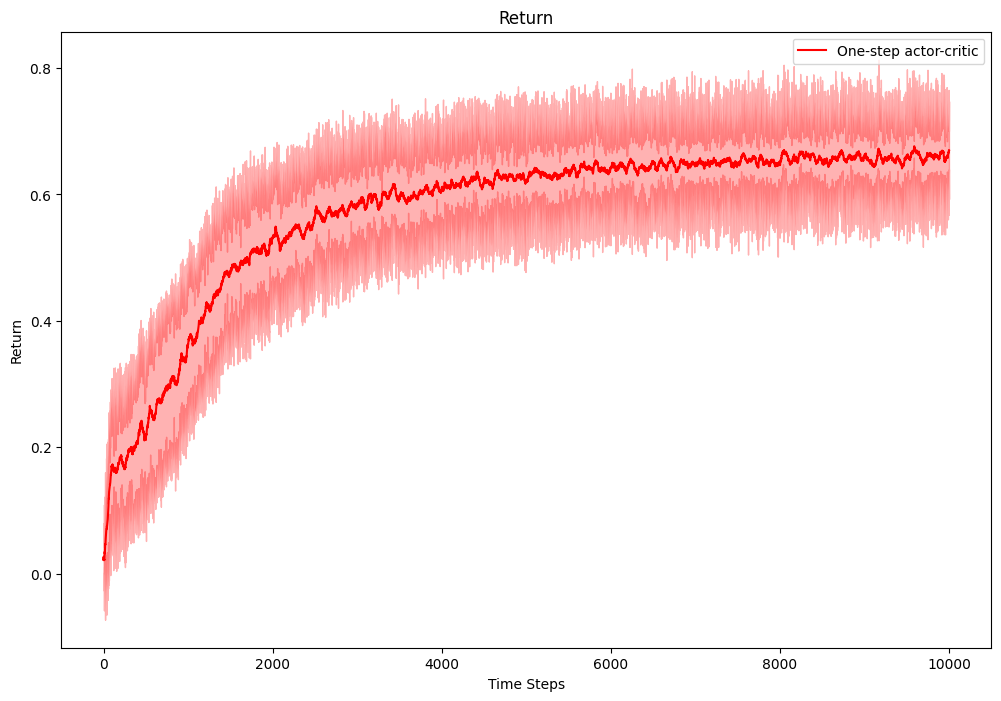

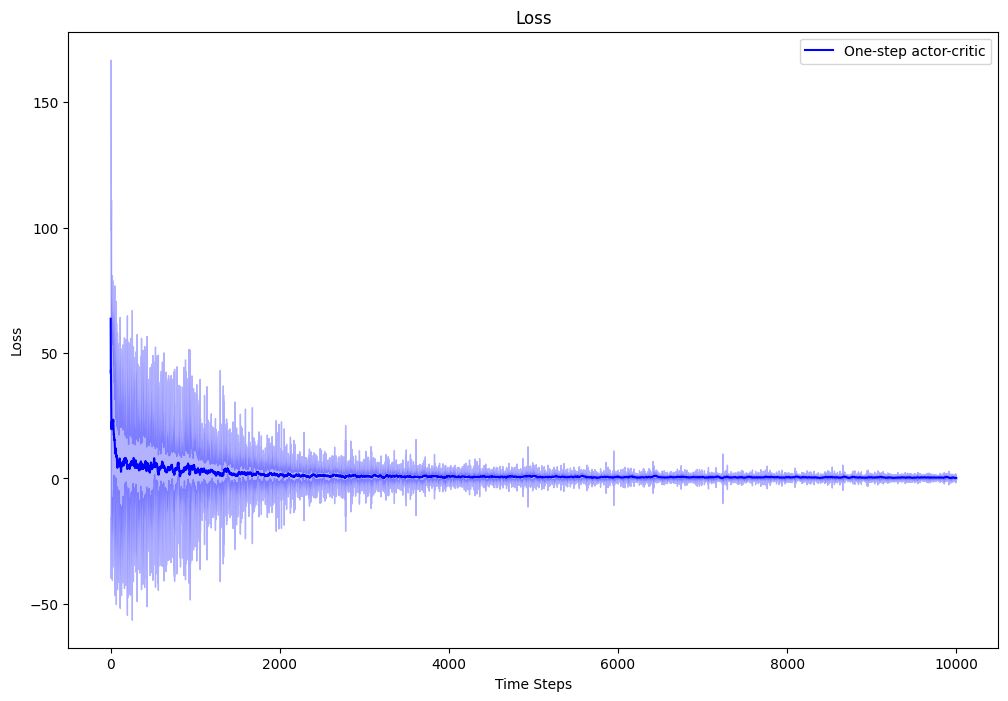

In [19]:
plot_curves([np.array(actor_critic_returns)], ['One-step actor-critic'], ['r'], 'Return', 'Return', smoothing = True)
plot_curves([np.array(actor_critic_losses)], ['One-step actor-critic'], ['b'], 'Loss', 'Loss', smoothing = True)

## Part (d): Compare REINFORCE, REINFORCE with baseline, and one-step actor-critic.

Compare the performance of these three methods and discuss your findings below.

Optional: Also compare against their tabular value-based counterparts (Monte-Carlo control and one-step SARSA), e.g., using results/implementations from previous assignments.

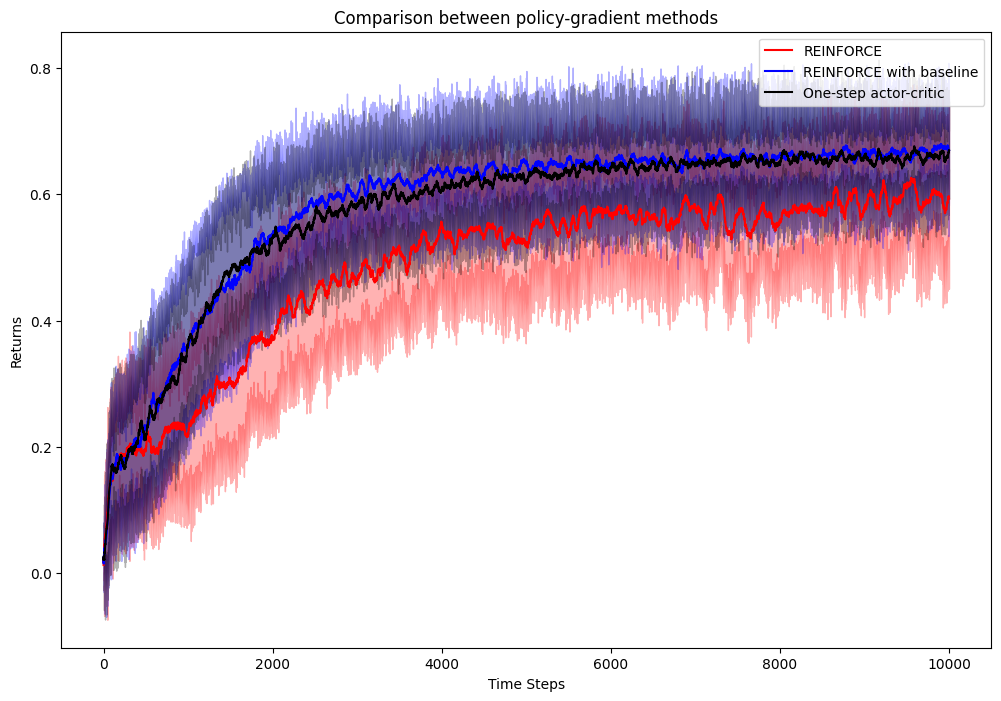

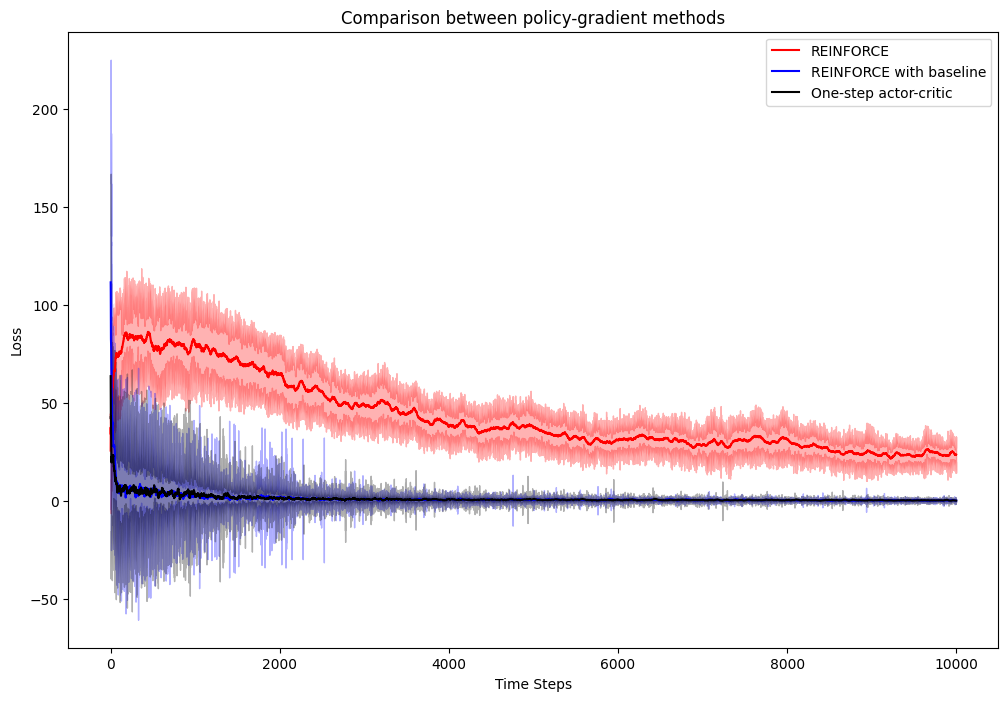

In [20]:
plot_curves([np.array(reinforce_returns), np.array(reinforce_baseline_returns), np.array(actor_critic_returns)], 
            ['REINFORCE', 'REINFORCE with baseline', 'One-step actor-critic'], 
            ['r', 'b', 'k'], 'Returns', "Comparison between policy-gradient methods")
plot_curves([np.array(reinforce_losses), np.array(reinforce_baseline_losses), np.array(actor_critic_losses)], 
            ['REINFORCE', 'REINFORCE with baseline', 'One-step actor-critic'], 
            ['r', 'b', 'k'], 'Loss', "Comparison between policy-gradient methods")

Analysis: YOUR ANSWER HERE.
Based on the two images you've uploaded, which appear to depict loss and returns over time for three different policy-gradient methods (REINFORCE, REINFORCE with baseline, and One-step actor-critic), here is an analysis:

### Returns Over Time
The first image illustrates the returns (cumulative rewards) over time for each method:
- **REINFORCE**: The red line again starts lower than the others, indicating poorer performance at the beginning. It shows improvement over time but does not reach the level of returns that the other methods achieve. The variance seems to remain quite high throughout the training process.
- **REINFORCE with Baseline**: The blue line shows that incorporating a baseline into REINFORCE leads to better performance than plain REINFORCE. The method appears to yield higher returns more quickly, which then improve at a slower rate. The variance also appears to decrease over time, suggesting more consistent performance as the policy improves.
- **One-step Actor-Critic**: The black line for the One-step actor-critic method starts off with returns comparable to REINFORCE with baseline but continues to improve over time, ending up with the highest returns. The method appears to learn more effectively, as evidenced by the consistently higher returns. The variance seems comparable to REINFORCE with baseline, if not slightly higher towards the end of the training.

### Loss Over Time
The second image shows the loss over time for each method:
- **REINFORCE**: The red line indicates that the REINFORCE method starts with a higher loss that decreases rapidly. However, it seems to plateau with some variance as time progresses. The large initial loss suggests that the policy starts far from optimal, which is expected since REINFORCE relies on high-variance Monte Carlo estimates of the returns.
- **REINFORCE with Baseline**: The blue line, representing REINFORCE with baseline, also starts high but decreases and stabilizes quicker than REINFORCE without a baseline. This indicates that using a baseline reduces the variance of the policy updates and leads to a more stable and possibly quicker convergence.
- **One-step Actor-Critic**: The black line for the One-step actor-critic method shows a lower initial loss that decreases steadily. This suggests that the actor-critic method, which leverages the advantage of both policy gradient and value function approximation, possibly converges more efficiently. The steadiness of the line could imply more consistent learning with each timestep.



### Overall Analysis
- **Convergence**: The actor-critic method appears to converge to a better policy than the other two methods, as suggested by the higher returns and lower loss over time.
- **Efficiency**: REINFORCE with baseline improves learning efficiency compared to plain REINFORCE, which is expected as the baseline reduces the variance of policy updates.
- **Stability**: All methods improve in stability over time, but the actor-critic and REINFORCE with baseline methods demonstrate more stable learning than plain REINFORCE.
- **Performance**: Based on returns, the actor-critic method seems to perform the best, followed by REINFORCE with baseline, and then plain REINFORCE.


- **Environment Complexity**: The effectiveness of each method can vary depending on the complexity of the environment. Complex environments may further differentiate the performance of these methods.
- **Hyperparameters**: Tuning of hyperparameters can significantly affect the performance of each method. It would be worth examining if the hyperparameters are optimally set for each method.
- **Statistical Significance**: Multiple runs would be needed to assess the statistical significance of these observations, as individual runs can be influenced by stochastic elements.

## [Extra credit.] Part (e): Advanced policy-gradient algorithms

Many deep policy-gradient algorithms have been proposed in the past 10 years. Read about and implement one or more of these from scratch (e.g., DDPG, TD3, PPO, SAC) and evaluate them on Four Rooms. Compare with the methods above and discuss your findings.

We recommend that you first read about some of these algorithms on OpenAI's "Spinning up in deep RL" pages, although you should not directly use their implementations in this assignment.\
https://spinningup.openai.com/en/latest/user/algorithms.html